In [2]:
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import plotly.express as px
import re
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler

In [3]:
alligator_annotations_github_testset = "../Results/alligator_annotations_github-testset_babakAlessandro_02_Github_Testset.json"

In [4]:
with open(alligator_annotations_github_testset, 'r') as f:
    data = json.load(f)

## Question: Which features are most important in finding the correct candidate?

### A.1 relation of each score to a candidate being the correct one
Let's have a look at how each feature is correlated to a candidate's correctness.

Suspicions:
- More than one correct candidate in the list => The first candidate is always duplicated, no matter if its correct or not.
- Are candidates closely ranked? => yes they are
- Why are all duplicated correct candidates ranked 1 and 0? Are all 0 ranked correct candidates duplicated? => All mentions that are correctly predicted (Their rank is 1) have duplicated values in the candidates.
- How many do not have any correct candidate? => 289 rows don't have correct. All are NIL values, the rest did not have any candidate there for are not in the df.
- There are 3 rows that do ot have any correct candidate and are not NIL. I assumed Lamapi adds the correct candidate in the list. ??

In [5]:
## Find correct Qid for each row
correct_Qid = {row["idRow"]:row.get("ids", 'NIL') for row in data["rows"]}
rows = []

## For each annotation extract features and append binary value if the entity is correct
for annotation in data["semanticAnnotations"]["cea"]:
    for index, entity in enumerate(annotation["entity"]):
        is_correct = False
        # Check if the entity is correct
        if entity["id"] in correct_Qid[annotation["idRow"]]:
            is_correct = True

        id_row = annotation.get('idRow')
        id_column = annotation.get('idColumn')

        # Generate the key in the format "{idRow}-{idColumn}"
        key = f"{id_row}-{id_column}-{index}"

        # Extract features as a dictionary
        features = {feature['id']: feature['value'] for feature in entity.get('features', [])}
        features['key'] = key  # Include the custom key in the DataFrame
        features['is_correct'] = is_correct
        features['idRow'] = id_row
        features['idColumn'] = id_column
        features['index'] = index

        # Append the features dictionary to rows
        rows.append(features)

# Create DataFrame and set 'key' as index
candidate_features = pd.DataFrame(rows).set_index('key')

# sort by column name
candidate_features_sub = candidate_features.drop(columns=['idRow', 'idColumn', 'index', 'is_correct'])
candidate_features_sub.sort_index(inplace=True, axis=1)
candidate_features_sub[['idRow', 'idColumn', 'index', 'is_correct']] = candidate_features[['idRow', 'idColumn', 'index', 'is_correct']]
candidate_features = candidate_features_sub

candidate_features_preprocessed = candidate_features.copy()

Since there were duplicates in the data (duplicated correct candidates) we need to remove them.

In [6]:
# remove duplicates
candidate_features_preprocessed = candidate_features.drop_duplicates(subset=candidate_features.columns.difference(['idColumn', 'index']))

#### Some Stats
Let's see how these features are distributed.

In [7]:
def extract_distribution_statistics(features_df):
    """
    Extracts statistical parameters for each feature in the DataFrame for distribution analysis.

    Parameters:
        features_df (pd.DataFrame): A DataFrame containing feature columns.

    Returns:
        pd.DataFrame: A DataFrame with ordered statistical parameters (mean, std_dev, min, 25%, median, 75%, max) for each feature.
    """
    # Initialize a dictionary to store statistics
    statistics = {}

    # Loop through each feature column to calculate statistics
    for column in features_df.columns:
        # Skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(features_df[column]):
            continue

        # Calculate statistical parameters
        stats = {
            'mean': features_df[column].mean(),
            'std_dev': features_df[column].std(),
            'min': features_df[column].min(),
            '25%': features_df[column].quantile(0.25),
            'median': features_df[column].median(),
            '75%': features_df[column].quantile(0.75),
            'max': features_df[column].max(),
        }

        # Add stats to the dictionary
        statistics[column] = stats

    # Convert the statistics dictionary to a DataFrame
    stats_df = pd.DataFrame(statistics).T  # Transpose to make features as rows

    # Reorder columns
    stats_df = stats_df[['mean', 'std_dev', 'min', '25%', 'median', '75%', 'max']]

    return stats_df

feature_stat = extract_distribution_statistics(candidate_features_preprocessed.drop(columns=['idRow', 'idColumn', 'index', 'is_correct']))
feature_stat

,mean,std_dev,min,25%,median,75%,max
ambiguity_mention,0.055857,0.181704,0.000,0.000,0.000,0.021,1.000
cpa_t1,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000
cpa_t2,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000
cpa_t3,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000
cpa_t4,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000
cpa_t5,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000
cta_t1,0.062261,0.087530,0.000,0.000,0.040,0.080,0.440
cta_t2,0.004327,0.020524,0.000,0.000,0.000,0.000,0.240
cta_t3,0.000760,0.007875,0.000,0.000,0.000,0.000,0.200
cta_t4,0.000184,0.003362,0.000,0.000,0.000,0.000,0.160


There are features with 0 std. They should be removed since they do not provide any information. These features are 0 because the input table has only one column.

In [8]:
zero_features = list(feature_stat[feature_stat['std_dev'] == 0].index)
zero_features

# Remove features with zero standard deviation
candidate_features_preprocessed = candidate_features_preprocessed.drop(columns=zero_features)

In [23]:
print(zero_features)

['cpa_t1', 'cpa_t2', 'cpa_t3', 'cpa_t4', 'cpa_t5', 'p_obj_ne', 'p_subj_lit_all_datatype', 'p_subj_lit_datatype', 'p_subj_lit_row', 'p_subj_ne']


Normalize feature values for better understanding and compariblity

In [9]:
candidate_features_preprocessed.columns

Index(['ambiguity_mention', 'cta_t1', 'cta_t2', 'cta_t3', 'cta_t4', 'cta_t5',
       'delta', 'desc', 'descNgram', 'ed_score', 'es_score',
       'jaccardNgram_score', 'jaccard_score', 'length_entity',
       'length_mention', 'ncorrects_tokens', 'ntoken_entity', 'ntoken_mention',
       'omega', 'popularity', 'pos_score', 'idRow', 'idColumn', 'index',
       'is_correct'],
      dtype='object')

In [10]:
# normalize each column using min max
scaler = MinMaxScaler()
candidate_features_preprocessed[candidate_features_preprocessed.columns.difference(["is_correct", 'idRow', 'idColumn', 'index'])] = scaler.fit_transform(candidate_features_preprocessed.drop(columns=["is_correct", 'idRow', 'idColumn', 'index']))

#### Some Plotting 
to see how incorrect and correct candidates differ in feature values.

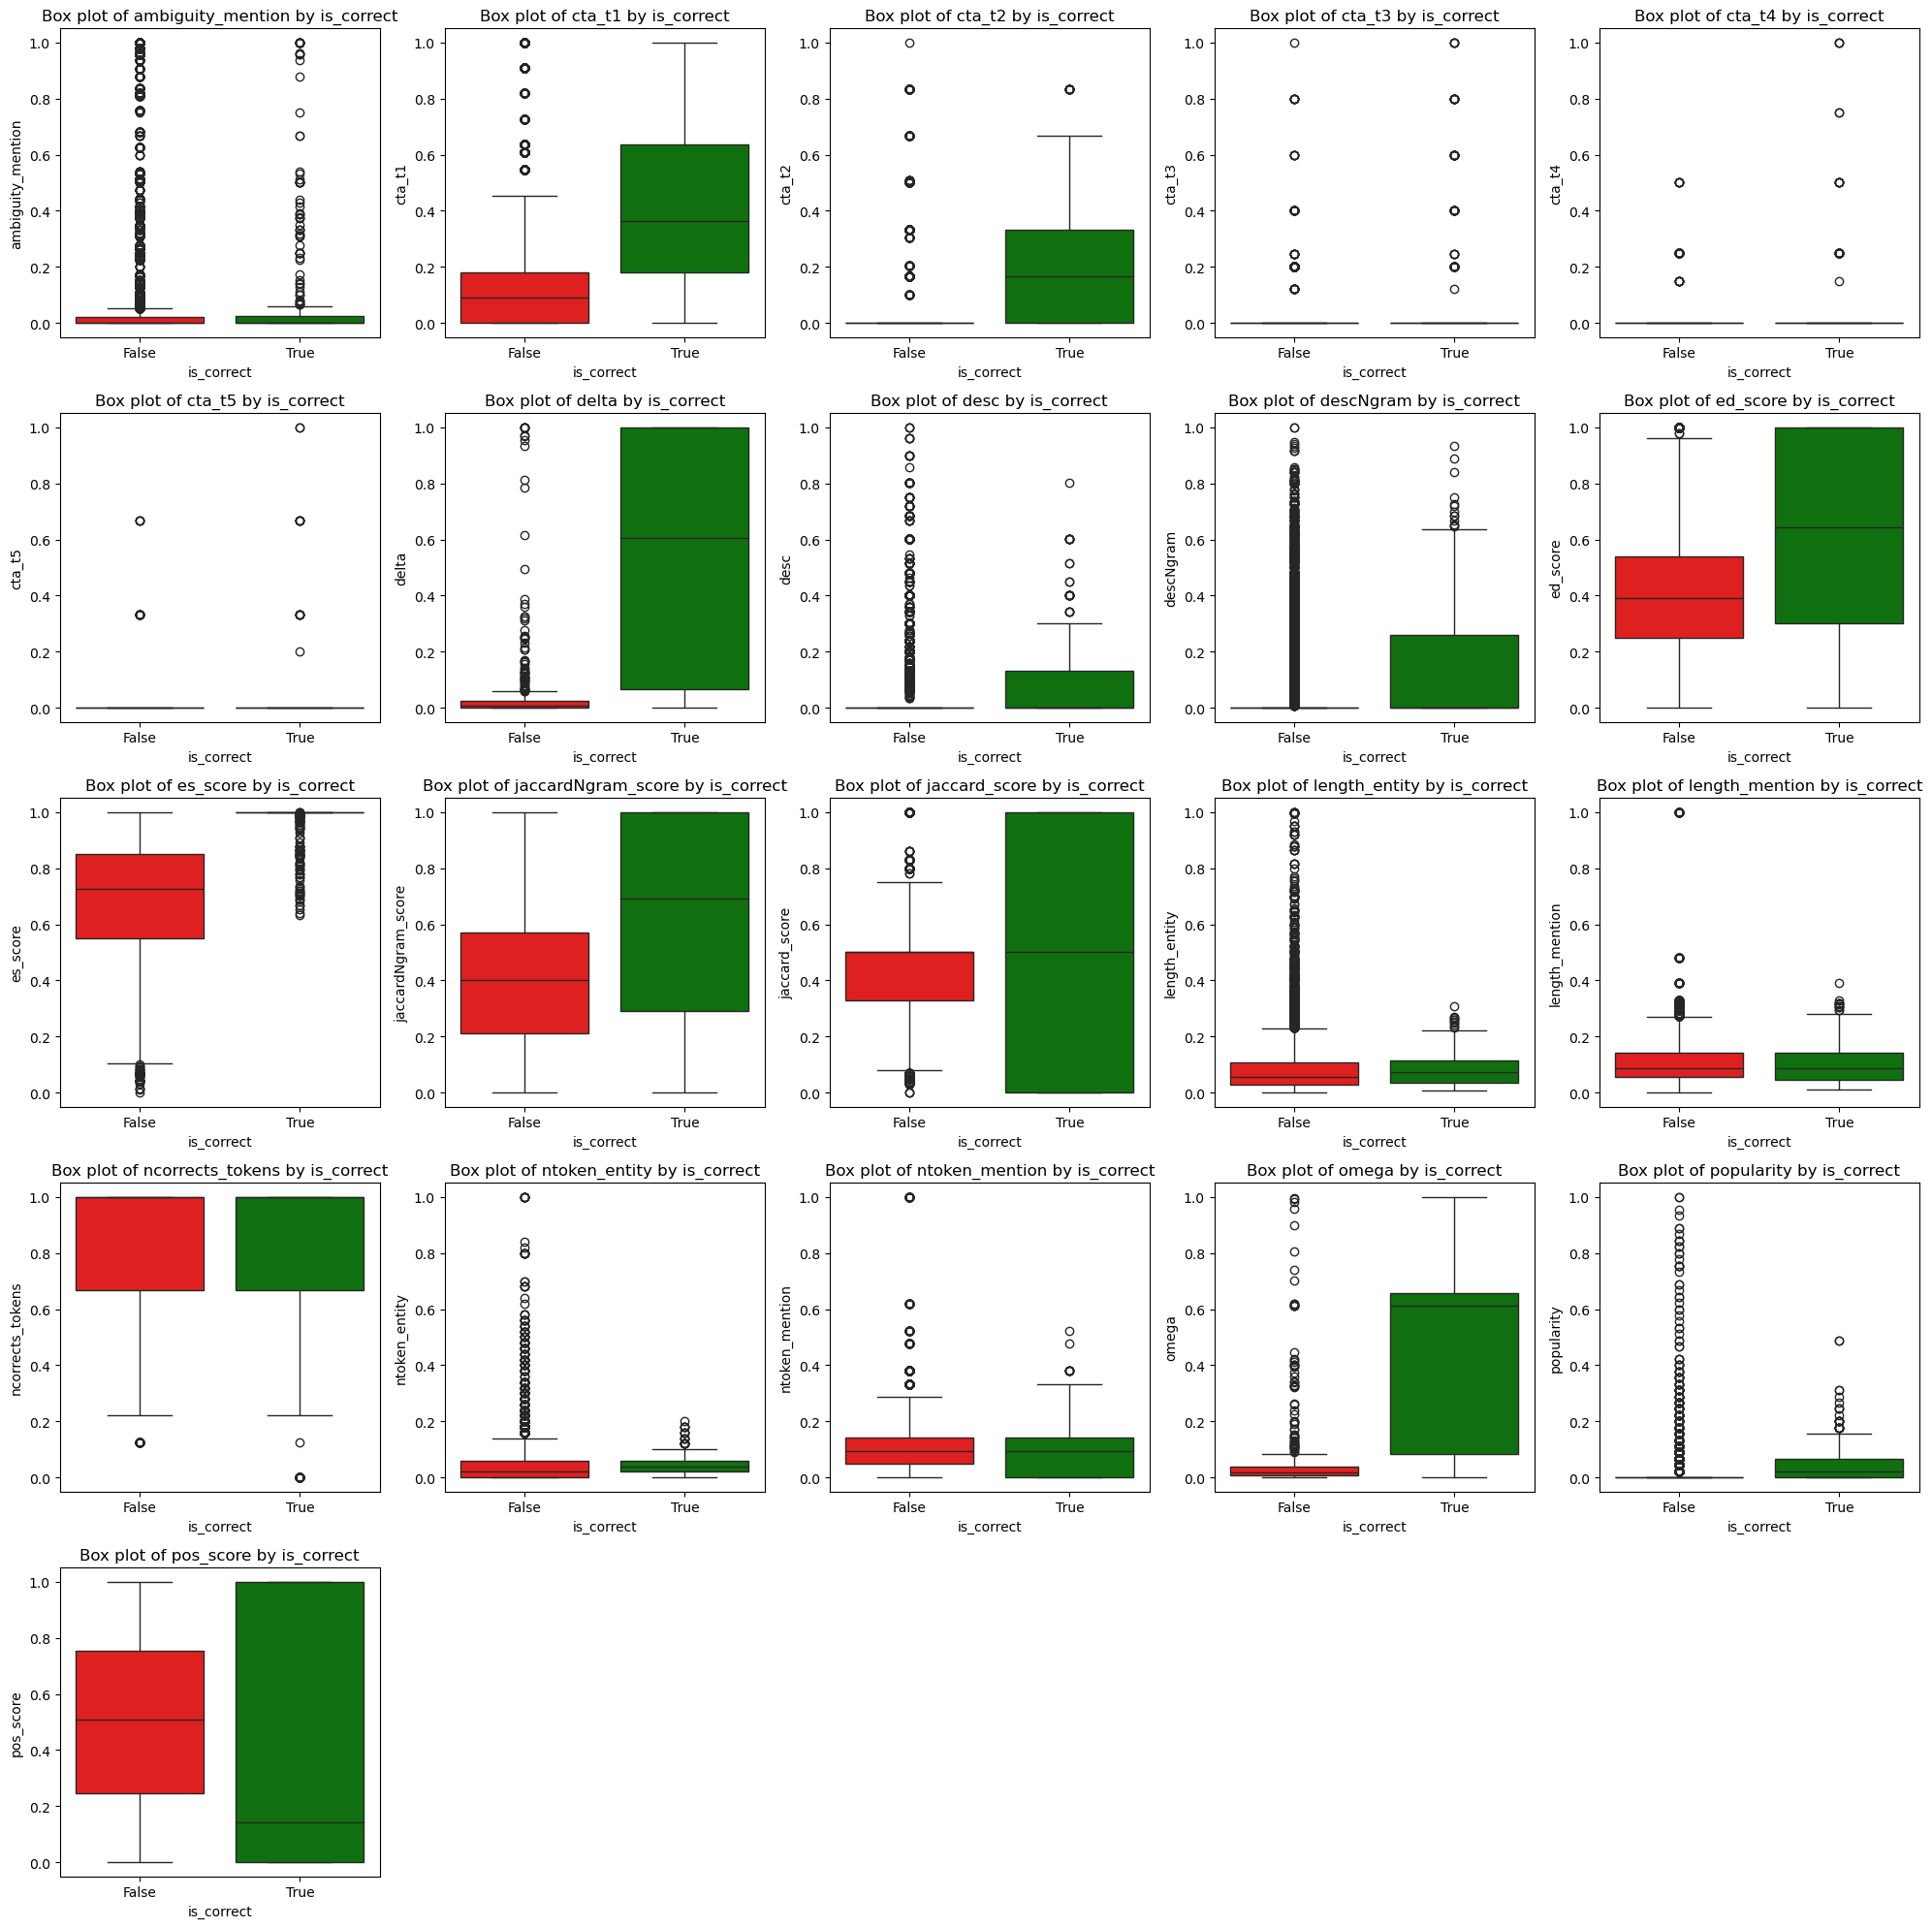

In [11]:
# List of columns to exclude
exclude_columns = ['idRow', 'idColumn', 'index', 'is_correct']

# Get the list of features to plot
features = [col for col in candidate_features_preprocessed.columns if col not in exclude_columns]

# Number of columns in the grid
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create box plots for each feature
for i, feature in enumerate(features):
    sns.boxplot(x='is_correct', y=feature, data=candidate_features_preprocessed, ax=axes[i], hue= 'is_correct', palette={False: 'red', True: 'green'}, legend=False)
    axes[i].set_title(f'Box plot of {feature} by is_correct')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

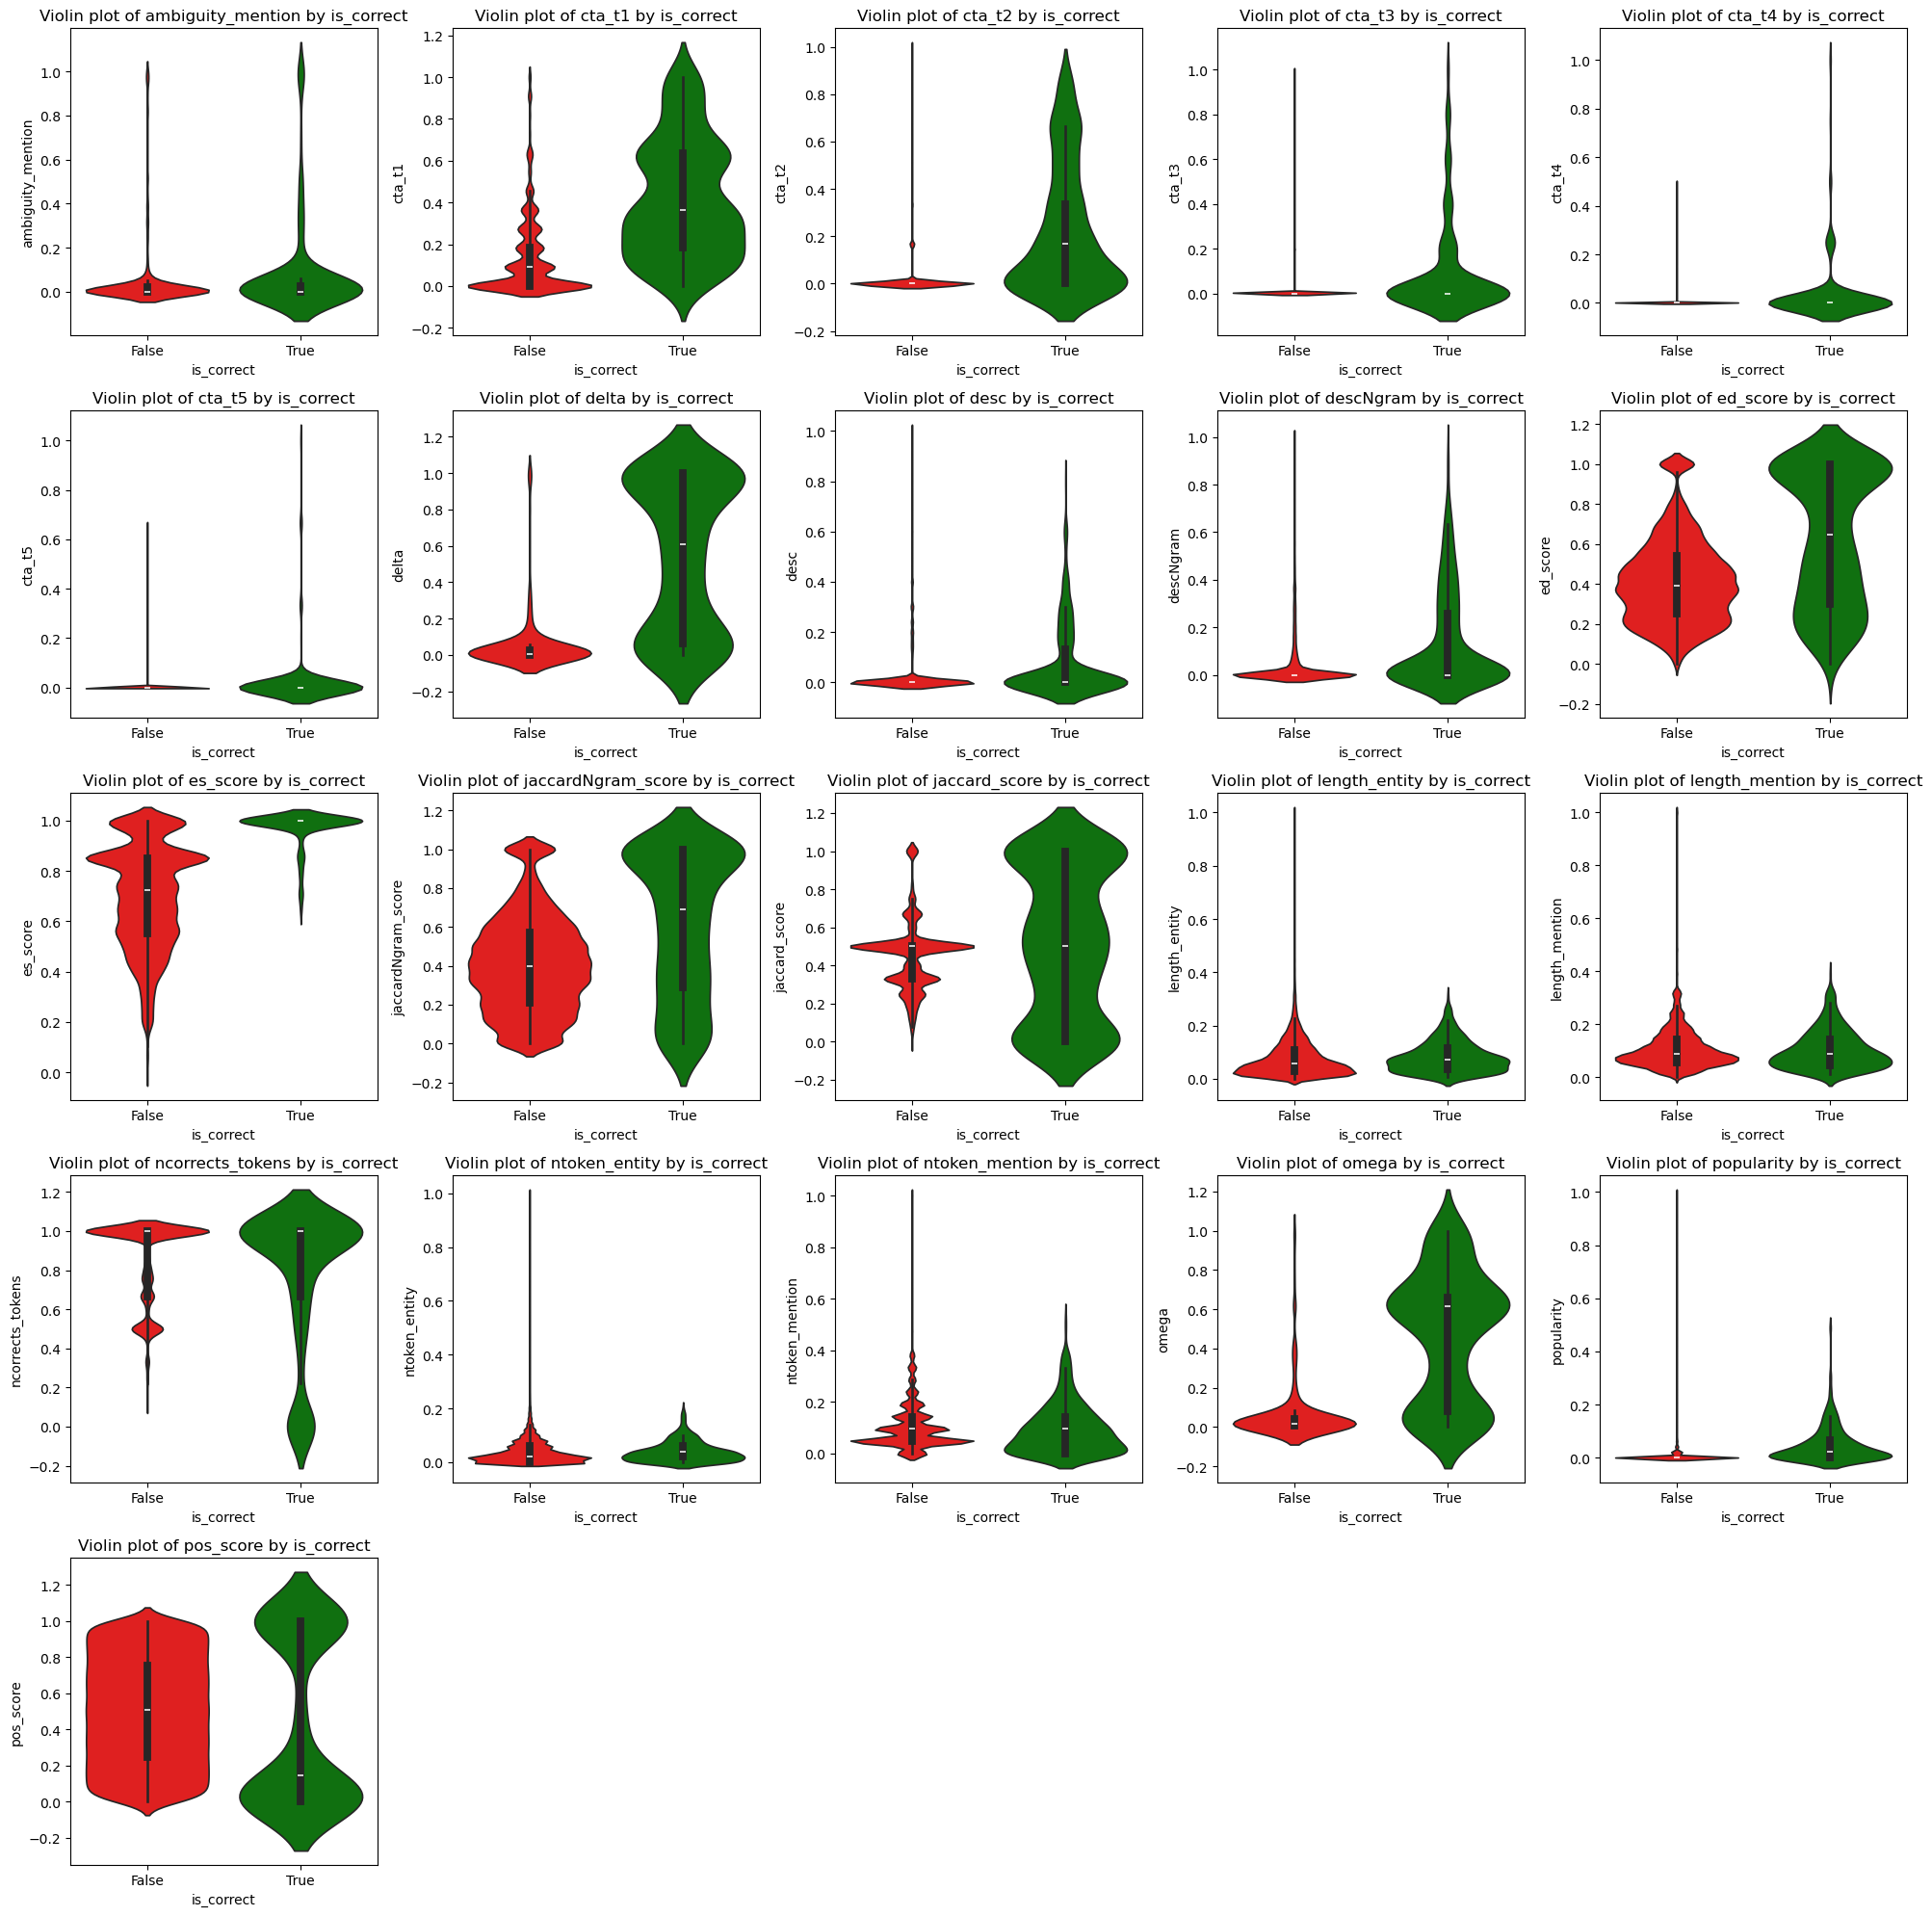

In [12]:
# List of columns to exclude
exclude_columns = ['idRow', 'idColumn', 'index', 'is_correct']

# Get the list of features to plot
features = [col for col in candidate_features_preprocessed.columns if col not in exclude_columns]

# Number of columns in the grid
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create violin plots for each feature
for i, feature in enumerate(features):
    sns.violinplot(x='is_correct', y=feature, data=candidate_features_preprocessed, ax=axes[i], hue= 'is_correct', palette={False: 'red', True: 'green'}, legend=False)
    axes[i].set_title(f'Violin plot of {feature} by is_correct')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
import scipy.stats as stats
from sklearn import preprocessing

In [14]:
le = preprocessing.LabelEncoder()
encded_is_correct = le.fit_transform(candidate_features_preprocessed['is_correct'])
le.classes_

array([False,  True])

In [15]:
# drop columns with missing values
candidate_features_cor = candidate_features_preprocessed.dropna(axis=1)
candidate_features_cor = candidate_features_cor.drop(columns=['is_correct', 'idRow', 'idColumn', 'index'])
candidate_features_cor["is_correct"] = encded_is_correct


In [20]:
cor_values = []

for col in candidate_features_cor.columns:
    if col != 'is_correct':
        cor_val = {}
        cor_val["feature"] = col
        cor_val["pointbiserialr"], cor_val["P-Value"] = stats.pointbiserialr(candidate_features_cor[col], candidate_features_cor['is_correct'])
        cor_val["pointbiserialr"] = round(cor_val["pointbiserialr"], 2)
        cor_val["P-Value"] = round(cor_val["P-Value"], 2)
        cor_values.append(cor_val)

pointbiserialr_values_df = pd.DataFrame(cor_values)
pointbiserialr_values_df["abs"] = pointbiserialr_values_df["pointbiserialr"].abs()
pointbiserialr_values_df = pointbiserialr_values_df.sort_values(by="abs", ascending=False)
pointbiserialr_values_df = pointbiserialr_values_df.drop(columns=["abs"])
pointbiserialr_values_df.reset_index(drop=True, inplace=True)
pointbiserialr_values_df

,feature,pointbiserialr,P-Value
0,cta_t2,0.31,0.00
1,cta_t3,0.30,0.00
2,cta_t4,0.20,0.00
3,cta_t1,0.17,0.00
4,es_score,0.16,0.00
5,popularity,0.14,0.00
6,cta_t5,0.13,0.00
7,ed_score,0.12,0.00
8,descNgram,0.10,0.00
9,jaccardNgram_score,0.10,0.00


### Answers
- cta features have the highest correlation with candidate correctness. 
    - Hyp 1: Doing a type filtering using the data present in the input table helps filter out irrelevant candidates.

- es-score is the second important feature. Calculated by Lamapi.

- ed-score distance of single char edits.

- Interestingly, pos score is close to zero. making IR system's ranking irrelevant.

## Question 2:
We need to know whic features are correlated together

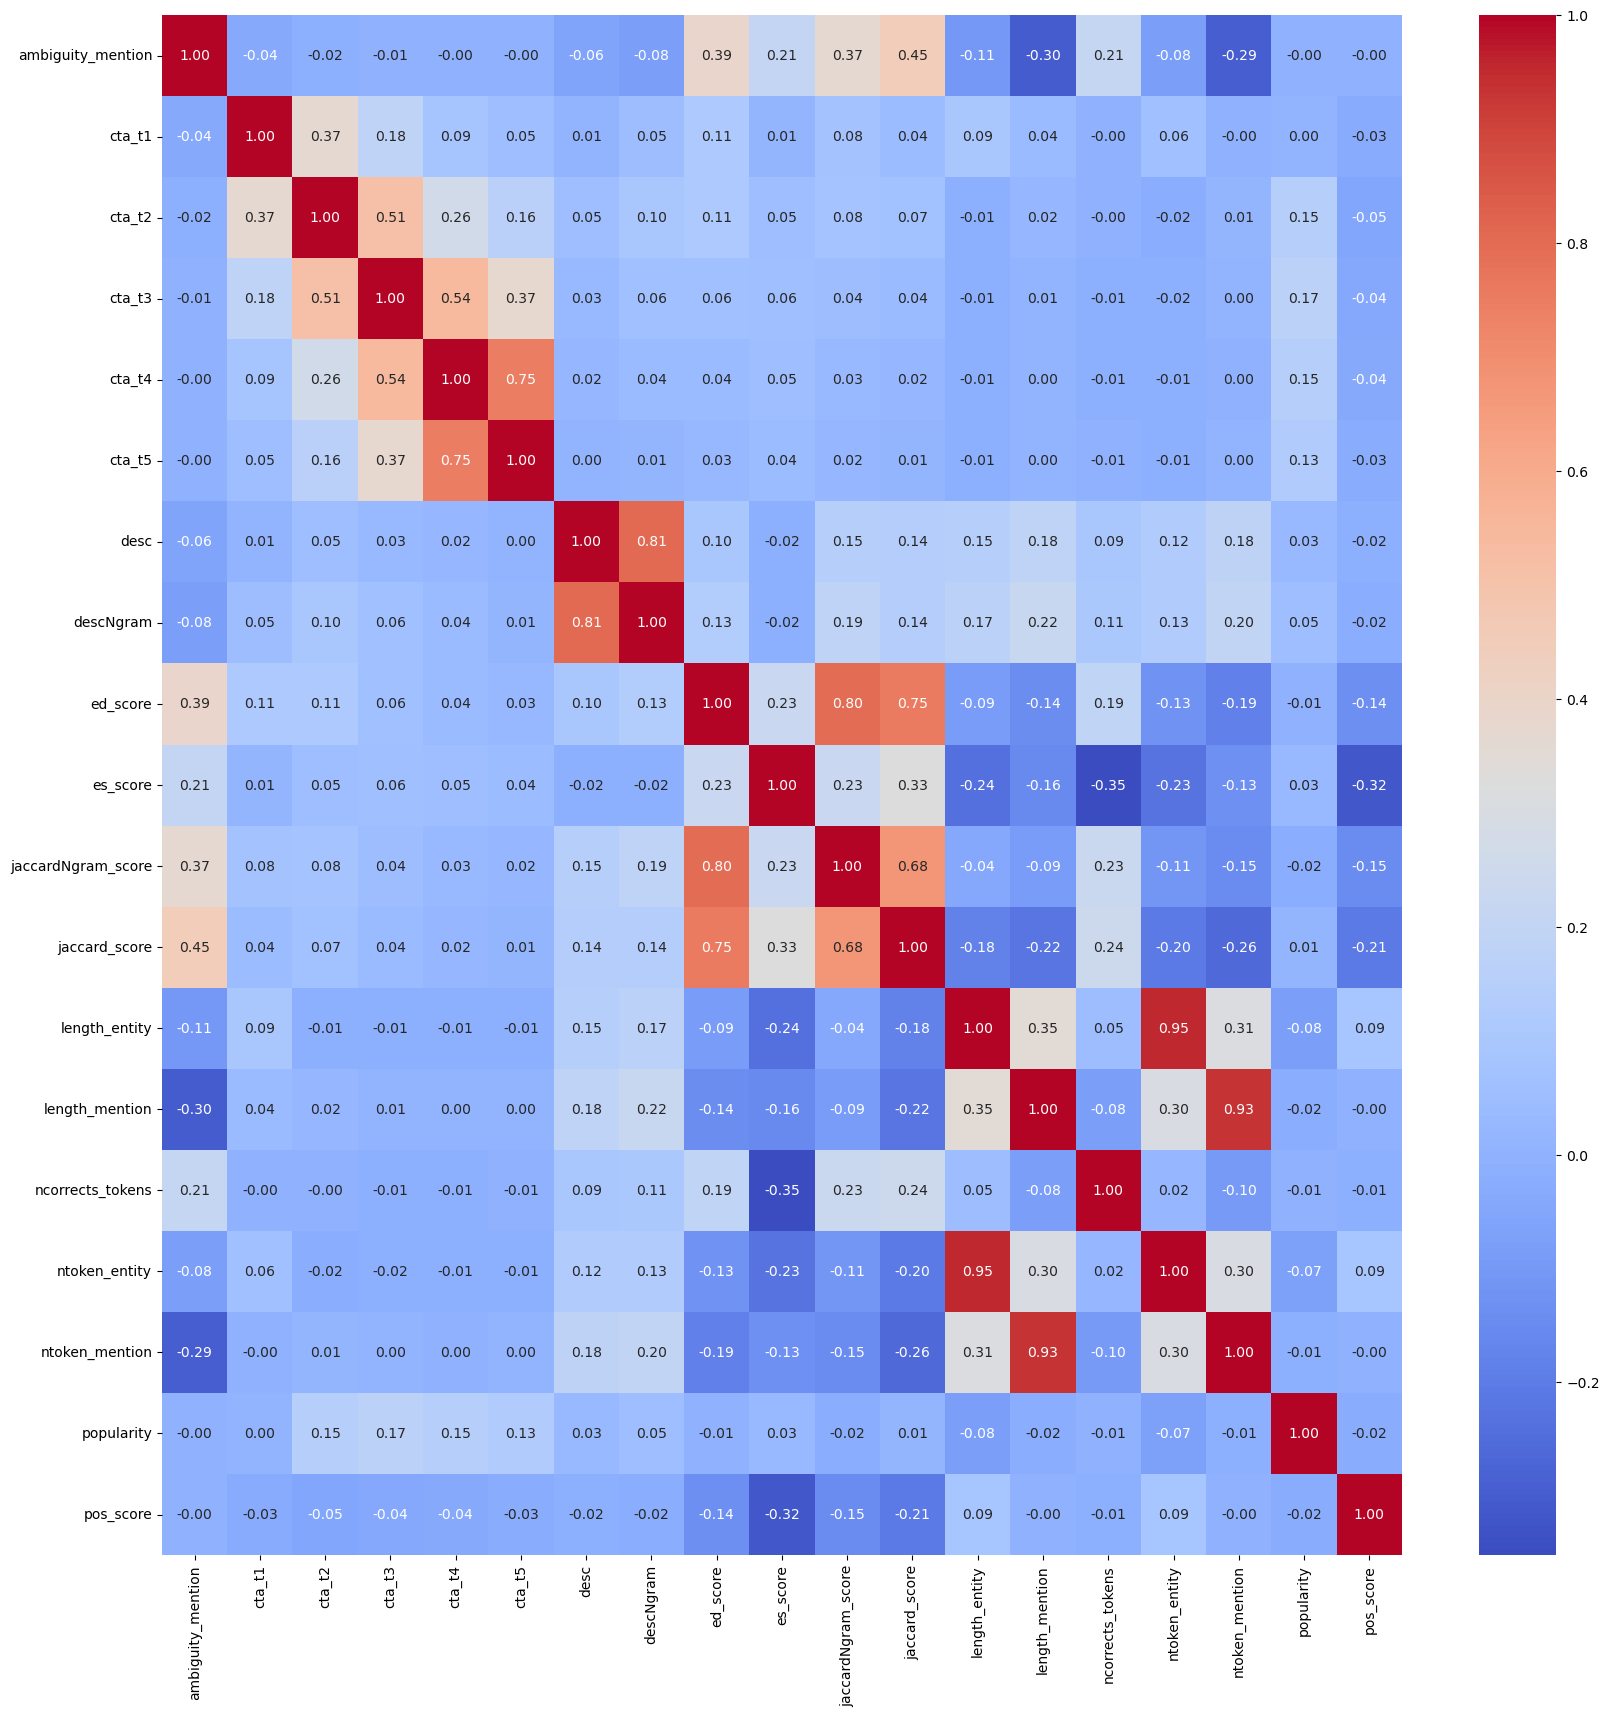

In [17]:
# correlation of features with eachother
corr = candidate_features_cor.drop(columns=["is_correct"]).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [19]:
# top 5 pairs of features with highest correlation
corr_pairs = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs.reset_index()
corr_pairs.columns = ["feature1", "feature2", "correlation"]
corr_pairs = corr_pairs.head(10)
corr_pairs

,feature1,feature2,correlation
0,ntoken_entity,length_entity,0.954697
1,ntoken_mention,length_mention,0.934969
2,desc,descNgram,0.809671
3,ed_score,jaccardNgram_score,0.795042
4,ed_score,jaccard_score,0.753745
5,cta_t4,cta_t5,0.749702
6,jaccardNgram_score,jaccard_score,0.677639
7,cta_t4,cta_t3,0.537120
8,cta_t2,cta_t3,0.513309
9,jaccard_score,ambiguity_mention,0.450059
